

Graph Neural Networks - II
====================================


In [2]:
%matplotlib inline

GCN
------------------------------------------




In [1]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [2]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

The forward function is essentially the same as any other commonly seen NNs
model in PyTorch.  We can initialize GCN like any ``nn.Module``. For example,
let's define a simple neural network consisting of two GCN layers. Suppose we
are training the classifier for the cora dataset (the input feature size is
1433 and the number of classes is 7). The last GCN layer computes node embeddings,
so the last layer in general does not apply activation.



In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(1433, 16)
        self.layer2 = GCNLayer(16, 7)
    
    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x
net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=True)
  )
)


We load the cora dataset using DGL's built-in data module.



In [46]:
data = citegrh.load_cora()
print(data.name)
print(data.features.shape)
print(data.num_labels)
print(data.train_mask.shape)
print(data.test_mask.shape)
print(data.val_mask.shape)


cora
(2708, 1433)
7
(2708,)
(2708,)
(2708,)


In [4]:
from dgl.data import citation_graph as citegrh
import networkx as nx
def load_cora_data():
    data = citegrh.load_cora()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    train_mask = th.BoolTensor(data.train_mask)
    test_mask = th.BoolTensor(data.test_mask)
    g = DGLGraph(data.graph)
    return g, features, labels, train_mask, test_mask

In [5]:
g,f,l,tra_m,tst_m = load_cora_data()

In [6]:
print(g.number_of_nodes())
print(g.number_of_edges())

2708
10556


In [39]:
import dgl
import dgl.function as fn
import torch as th

g.ndata['h'] = th.randn((g.number_of_nodes(), 44)) # each node has feature size 10
g.edata['w'] = th.randn((g.number_of_edges(), 11))  # each edge has feature size 1
# collect features from source nodes and aggregate them in destination nodes
#g.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h_sum'))
# multiply source node features with edge weights and aggregate them in destination nodes
#g.update_all(fn.u_mul_e('h', 'w', 'm'), fn.max('m', 'h_max'))
# compute edge embedding by multiplying source and destination node embeddings
g.apply_edges(fn.u_mul_v('h', 'h', 'w_new'))

print(g.ndata['h'].shape)
print(g.edata['w'].shape)

#print(g.ndata['h_max'].shape)
print(g.edata['w_new'].shape)
print(g.node_attr_schemes())
print(g.edge_attr_schemes())
#print(g.ndata['h_sum'].shape)

torch.Size([2708, 44])
torch.Size([10556, 11])
torch.Size([10556, 44])
{'h': Scheme(shape=(44,), dtype=torch.float32), 'h_sum': Scheme(shape=(1,), dtype=torch.float32), 'h_max': Scheme(shape=(11,), dtype=torch.float32)}
{'w': Scheme(shape=(11,), dtype=torch.float32), 'w_new': Scheme(shape=(44,), dtype=torch.float32)}


In [40]:
print(g,"\n",f.shape,l.shape,tra_m.shape,tst_m.shape)

DGLGraph(num_nodes=2708, num_edges=10556,
         ndata_schemes={'h': Scheme(shape=(44,), dtype=torch.float32), 'h_sum': Scheme(shape=(1,), dtype=torch.float32), 'h_max': Scheme(shape=(11,), dtype=torch.float32)}
         edata_schemes={'w': Scheme(shape=(11,), dtype=torch.float32), 'w_new': Scheme(shape=(44,), dtype=torch.float32)}) 
 torch.Size([2708, 1433]) torch.Size([2708]) torch.Size([2708]) torch.Size([2708])


In [20]:
print(l[:10],tra_m,tst_m)

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6]) tensor([ True,  True,  True,  ..., False, False, False]) tensor([False, False, False,  ..., False, False, False])


When a model is trained, we can use the following method to evaluate
the performance of the model on the test dataset:



In [8]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

We then train the network as follows:



In [9]:
import time
import numpy as np
g, features, labels, train_mask, test_mask = load_cora_data()
optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
dur = []
for epoch in range(50):
    if epoch >=3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch >=3:
        dur.append(time.time() - t0)
    
    acc = evaluate(net, g, features, labels, test_mask)
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, np.mean(dur)))

Epoch 00000 | Loss 1.9510 | Test Acc 0.3900 | Time(s) nan
Epoch 00001 | Loss 1.7846 | Test Acc 0.4260 | Time(s) nan
Epoch 00002 | Loss 1.6153 | Test Acc 0.5050 | Time(s) nan
Epoch 00003 | Loss 1.4636 | Test Acc 0.5580 | Time(s) 0.1190
Epoch 00004 | Loss 1.3350 | Test Acc 0.6050 | Time(s) 0.1210
Epoch 00005 | Loss 1.2277 | Test Acc 0.6290 | Time(s) 0.1207
Epoch 00006 | Loss 1.1408 | Test Acc 0.6480 | Time(s) 0.1208
Epoch 00007 | Loss 1.0667 | Test Acc 0.6630 | Time(s) 0.1206
Epoch 00008 | Loss 1.0003 | Test Acc 0.6900 | Time(s) 0.1207
Epoch 00009 | Loss 0.9391 | Test Acc 0.7020 | Time(s) 0.1225
Epoch 00010 | Loss 0.8818 | Test Acc 0.7100 | Time(s) 0.1230
Epoch 00011 | Loss 0.8282 | Test Acc 0.7210 | Time(s) 0.1238
Epoch 00012 | Loss 0.7777 | Test Acc 0.7290 | Time(s) 0.1240
Epoch 00013 | Loss 0.7303 | Test Acc 0.7360 | Time(s) 0.1243
Epoch 00014 | Loss 0.6857 | Test Acc 0.7370 | Time(s) 0.1241
Epoch 00015 | Loss 0.6441 | Test Acc 0.7420 | Time(s) 0.1262
Epoch 00016 | Loss 0.6047 | Test 

GAT
------------------------------------------

In [25]:
from dgl.nn.pytorch import GATConv
import torch
import torch.nn as nn
import torch.nn.functional as F


class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [29]:
def edge_attention(self, edges):
    # edge UDF for equation (2)
    z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
    a = self.attn_fc(z2)
    return {'e' : F.leaky_relu(a)}

def reduce_func(self, nodes):
    # reduce UDF for equation (3) & (4)
    # equation (3)
    alpha = F.softmax(nodes.mailbox['e'], dim=1)
    # equation (4)
    h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
    return {'h' : h}

In [30]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [31]:
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [33]:
import time
import numpy as np

g, features, labels, mask, test_mask = load_cora_data()

# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))

Epoch 00000 | Loss 1.9477 | Time(s) nan
Epoch 00001 | Loss 1.9456 | Time(s) nan
Epoch 00002 | Loss 1.9435 | Time(s) nan
Epoch 00003 | Loss 1.9414 | Time(s) 0.2371
Epoch 00004 | Loss 1.9393 | Time(s) 0.2326
Epoch 00005 | Loss 1.9372 | Time(s) 0.2361
Epoch 00006 | Loss 1.9351 | Time(s) 0.2383
Epoch 00007 | Loss 1.9330 | Time(s) 0.2397
Epoch 00008 | Loss 1.9309 | Time(s) 0.2426
Epoch 00009 | Loss 1.9288 | Time(s) 0.2447
Epoch 00010 | Loss 1.9267 | Time(s) 0.2432
Epoch 00011 | Loss 1.9245 | Time(s) 0.2435
Epoch 00012 | Loss 1.9224 | Time(s) 0.2428
Epoch 00013 | Loss 1.9203 | Time(s) 0.2425
Epoch 00014 | Loss 1.9181 | Time(s) 0.2445
Epoch 00015 | Loss 1.9160 | Time(s) 0.2439
Epoch 00016 | Loss 1.9138 | Time(s) 0.2457
Epoch 00017 | Loss 1.9116 | Time(s) 0.2489
Epoch 00018 | Loss 1.9094 | Time(s) 0.2528
Epoch 00019 | Loss 1.9072 | Time(s) 0.2543
Epoch 00020 | Loss 1.9050 | Time(s) 0.2526
Epoch 00021 | Loss 1.9028 | Time(s) 0.2546
Epoch 00022 | Loss 1.9006 | Time(s) 0.2549
Epoch 00023 | Loss 1

RGCN
------------------------------------------

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import dgl.function as fn
from functools import partial

class RGCNLayer(nn.Module):
    def __init__(self, in_feat, out_feat, num_rels, num_bases=-1, bias=None,
                 activation=None, is_input_layer=False):
        super(RGCNLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.num_rels = num_rels
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.is_input_layer = is_input_layer

        # sanity check
        if self.num_bases <= 0 or self.num_bases > self.num_rels:
            self.num_bases = self.num_rels

        # weight bases in equation (3)
        self.weight = nn.Parameter(torch.Tensor(self.num_bases, self.in_feat,
                                                self.out_feat))
        if self.num_bases < self.num_rels:
            # linear combination coefficients in equation (3)
            self.w_comp = nn.Parameter(torch.Tensor(self.num_rels, self.num_bases))

        # add bias
        if self.bias:
            self.bias = nn.Parameter(torch.Tensor(out_feat))

        # init trainable parameters
        nn.init.xavier_uniform_(self.weight,
                                gain=nn.init.calculate_gain('relu'))
        if self.num_bases < self.num_rels:
            nn.init.xavier_uniform_(self.w_comp,
                                    gain=nn.init.calculate_gain('relu'))
        if self.bias:
            nn.init.xavier_uniform_(self.bias,
                                    gain=nn.init.calculate_gain('relu'))

    def forward(self, g):
        if self.num_bases < self.num_rels:
            # generate all weights from bases (equation (3))
            weight = self.weight.view(self.in_feat, self.num_bases, self.out_feat)
            weight = torch.matmul(self.w_comp, weight).view(self.num_rels,
                                                        self.in_feat, self.out_feat)
        else:
            weight = self.weight

        if self.is_input_layer:
            def message_func(edges):
                # for input layer, matrix multiply can be converted to be
                # an embedding lookup using source node id
                embed = weight.view(-1, self.out_feat)
                index = edges.data['rel_type'] * self.in_feat + edges.src['id']
                return {'msg': embed[index] * edges.data['norm']}
        else:
            def message_func(edges):
                i = edges.data['rel_type'].type(torch.long)
                w = weight[i]
                msg = torch.bmm(edges.src['h'].unsqueeze(1), w).squeeze()
                msg = msg * edges.data['norm']
                return {'msg': msg}

        def apply_func(nodes):
            h = nodes.data['h']
            if self.bias:
                h = h + self.bias
            if self.activation:
                h = self.activation(h)
            return {'h': h}

        g.update_all(message_func, fn.sum(msg='msg', out='h'), apply_func)

Full R-GCN model defined
~~~~~~~~~~~~~~~~~~~~~~~

In [13]:
class Model(nn.Module):
    def __init__(self, num_nodes, h_dim, out_dim, num_rels,
                 num_bases=-1, num_hidden_layers=1):
        super(Model, self).__init__()
        self.num_nodes = num_nodes
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.num_rels = num_rels
        self.num_bases = num_bases
        self.num_hidden_layers = num_hidden_layers

        # create rgcn layers
        self.build_model()

        # create initial features
        self.features = self.create_features()

    def build_model(self):
        self.layers = nn.ModuleList()
        # input to hidden
        i2h = self.build_input_layer()
        self.layers.append(i2h)
        # hidden to hidden
        for _ in range(self.num_hidden_layers):
            h2h = self.build_hidden_layer()
            self.layers.append(h2h)
        # hidden to output
        h2o = self.build_output_layer()
        self.layers.append(h2o)

    # initialize feature for each node
    def create_features(self):
        features = torch.arange(self.num_nodes)
        return features

    def build_input_layer(self):
        return RGCNLayer(self.num_nodes, self.h_dim, self.num_rels, self.num_bases,
                         activation=F.relu, is_input_layer=True)

    def build_hidden_layer(self):
        return RGCNLayer(self.h_dim, self.h_dim, self.num_rels, self.num_bases,
                         activation=F.relu)

    def build_output_layer(self):
        return RGCNLayer(self.h_dim, self.out_dim, self.num_rels, self.num_bases,
                         activation=partial(F.softmax, dim=1))

    def forward(self, g):
        if self.features is not None:
            g.ndata['id'] = self.features
        for layer in self.layers:
            layer(g)
        return g.ndata.pop('h')

Handle dataset
~~~~~~~~~~~~~~~~
This tutorial uses Institute for Applied Informatics and Formal Description Methods (AIFB) dataset from R-GCN paper.

In [21]:
# load graph data
from dgl.contrib.data import load_data
import numpy as np
data = load_data(dataset='aifb')
num_nodes = data.num_nodes
num_rels = data.num_rels
num_classes = data.num_classes
labels = data.labels
train_idx = data.train_idx
# split training and validation set
val_idx = train_idx[:len(train_idx) // 5]
train_idx = train_idx[len(train_idx) // 5:]

# edge type and normalization factor
edge_type = torch.from_numpy(data.edge_type)
edge_norm = torch.from_numpy(data.edge_norm).unsqueeze(1)

labels = torch.from_numpy(labels).view(-1)

Loading dataset aifb
Number of nodes:  8285
Number of edges:  66371
Number of relations:  91
Number of classes:  4
removing nodes that are more than 3 hops away


Create graph and model
~~~~~~~~~~~~~~~~~~~~~~~

In [22]:
# configurations
n_hidden = 16 # number of hidden units
n_bases = -1 # use number of relations as number of bases
n_hidden_layers = 0 # use 1 input layer, 1 output layer, no hidden layer
n_epochs = 25 # epochs to train
lr = 0.01 # learning rate
l2norm = 0 # L2 norm coefficient

# create graph
g = DGLGraph((data.edge_src, data.edge_dst))
g.edata.update({'rel_type': edge_type, 'norm': edge_norm})

# create model
model = Model(len(g),
              n_hidden,
              num_classes,
              num_rels,
              num_bases=n_bases,
              num_hidden_layers=n_hidden_layers)

Training loop
~~~~~~~~~~~~~~~~

In [23]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2norm)

print("start training...")
model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    logits = model.forward(g)
    loss = F.cross_entropy(logits[train_idx], labels[train_idx].long())
    loss.backward()

    optimizer.step()

    train_acc = torch.sum(logits[train_idx].argmax(dim=1) == labels[train_idx])
    train_acc = train_acc.item() / len(train_idx)
    val_loss = F.cross_entropy(logits[val_idx], labels[val_idx].long())
    val_acc = torch.sum(logits[val_idx].argmax(dim=1) == labels[val_idx])
    val_acc = val_acc.item() / len(val_idx)
    print("Epoch {:05d} | ".format(epoch) +
          "Train Accuracy: {:.4f} | Train Loss: {:.4f} | ".format(
              train_acc, loss.item()) +
          "Validation Accuracy: {:.4f} | Validation loss: {:.4f}".format(
              val_acc, val_loss.item()))

start training...
Epoch 00000 | Train Accuracy: 0.3214 | Train Loss: 1.3857 | Validation Accuracy: 0.3214 | Validation loss: 1.3858
Epoch 00001 | Train Accuracy: 0.9375 | Train Loss: 1.3354 | Validation Accuracy: 0.8929 | Validation loss: 1.3498
Epoch 00002 | Train Accuracy: 0.9375 | Train Loss: 1.2598 | Validation Accuracy: 0.9643 | Validation loss: 1.2983
Epoch 00003 | Train Accuracy: 0.9464 | Train Loss: 1.1660 | Validation Accuracy: 0.9643 | Validation loss: 1.2310
Epoch 00004 | Train Accuracy: 0.9464 | Train Loss: 1.0742 | Validation Accuracy: 0.9643 | Validation loss: 1.1530
Epoch 00005 | Train Accuracy: 0.9464 | Train Loss: 0.9993 | Validation Accuracy: 0.9643 | Validation loss: 1.0735
Epoch 00006 | Train Accuracy: 0.9554 | Train Loss: 0.9413 | Validation Accuracy: 0.9643 | Validation loss: 1.0009
Epoch 00007 | Train Accuracy: 0.9554 | Train Loss: 0.8965 | Validation Accuracy: 0.9643 | Validation loss: 0.9409
Epoch 00008 | Train Accuracy: 0.9554 | Train Loss: 0.8618 | Validation

LGNN
------------------------------------------

In [35]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import dgl
from dgl.data import citation_graph as citegrh

data = citegrh.load_cora()

G = dgl.DGLGraph(data.graph)
labels = th.tensor(data.labels)

# find all the nodes labeled with class 0
label0_nodes = th.nonzero(labels == 0).squeeze()
# find all the edges pointing to class 0 nodes
src, _ = G.in_edges(label0_nodes)
src_labels = labels[src]
# find all the edges whose both endpoints are in class 0
intra_src = th.nonzero(src_labels == 0)
print('Intra-class edges percent: %.4f' % (len(intra_src) / len(src_labels)))

Intra-class edges percent: 0.7680


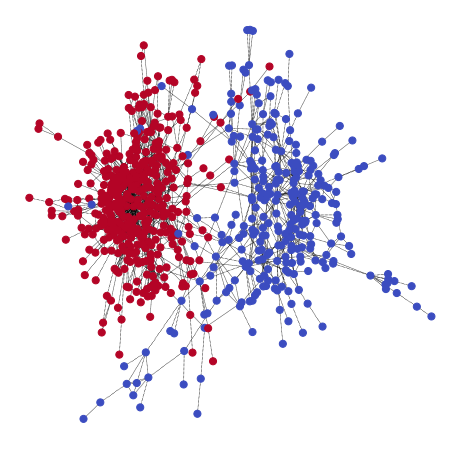

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

train_set = dgl.data.CoraBinary()
G1, pmpd1, label1 = train_set[1]
nx_G1 = G1.to_networkx()

def visualize(labels, g):
    pos = nx.spring_layout(g, seed=1)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=50, cmap=plt.get_cmap('coolwarm'),
                     node_color=labels, edge_color='k',
                     arrows=False, width=0.5, style='dotted', with_labels=False)
visualize(label1, nx_G1)

In [37]:
# Return a list containing features gathered from multiple radius.
import dgl.function as fn
def aggregate_radius(radius, g, z):
    # initializing list to collect message passing result
    z_list = []
    g.ndata['z'] = z
    # pulling message from 1-hop neighbourhood
    g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
    z_list.append(g.ndata['z'])
    for i in range(radius - 1):
        for j in range(2 ** i):
            #pulling message from 2^j neighborhood
            g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
        z_list.append(g.ndata['z'])
    return z_list

In [38]:
class LGNNCore(nn.Module):
    def __init__(self, in_feats, out_feats, radius):
        super(LGNNCore, self).__init__()
        self.out_feats = out_feats
        self.radius = radius

        self.linear_prev = nn.Linear(in_feats, out_feats)
        self.linear_deg = nn.Linear(in_feats, out_feats)
        self.linear_radius = nn.ModuleList(
                [nn.Linear(in_feats, out_feats) for i in range(radius)])
        self.linear_fuse = nn.Linear(in_feats, out_feats)
        self.bn = nn.BatchNorm1d(out_feats)

    def forward(self, g, feat_a, feat_b, deg, pm_pd):
        # term "prev"
        prev_proj = self.linear_prev(feat_a)
        # term "deg"
        deg_proj = self.linear_deg(deg * feat_a)

        # term "radius"
        # aggregate 2^j-hop features
        hop2j_list = aggregate_radius(self.radius, g, feat_a)
        # apply linear transformation
        hop2j_list = [linear(x) for linear, x in zip(self.linear_radius, hop2j_list)]
        radius_proj = sum(hop2j_list)

        # term "fuse"
        fuse = self.linear_fuse(th.mm(pm_pd, feat_b))

        # sum them together
        result = prev_proj + deg_proj + radius_proj + fuse

        # skip connection and batch norm
        n = self.out_feats // 2
        result = th.cat([result[:, :n], F.relu(result[:, n:])], 1)
        result = self.bn(result)

        return result

In [39]:
class LGNNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, radius):
        super(LGNNLayer, self).__init__()
        self.g_layer = LGNNCore(in_feats, out_feats, radius)
        self.lg_layer = LGNNCore(in_feats, out_feats, radius)

    def forward(self, g, lg, x, lg_x, deg_g, deg_lg, pm_pd):
        next_x = self.g_layer(g, x, lg_x, deg_g, pm_pd)
        pm_pd_y = th.transpose(pm_pd, 0, 1)
        next_lg_x = self.lg_layer(lg, lg_x, x, deg_lg, pm_pd_y)
        return next_x, next_lg_x

In [40]:
class LGNN(nn.Module):
    def __init__(self, radius):
        super(LGNN, self).__init__()
        self.layer1 = LGNNLayer(1, 16, radius)  # input is scalar feature
        self.layer2 = LGNNLayer(16, 16, radius)  # hidden size is 16
        self.layer3 = LGNNLayer(16, 16, radius)
        self.linear = nn.Linear(16, 2)  # predice two classes

    def forward(self, g, lg, pm_pd):
        # compute the degrees
        deg_g = g.in_degrees().float().unsqueeze(1)
        deg_lg = lg.in_degrees().float().unsqueeze(1)
        # use degree as the input feature
        x, lg_x = deg_g, deg_lg
        x, lg_x = self.layer1(g, lg, x, lg_x, deg_g, deg_lg, pm_pd)
        x, lg_x = self.layer2(g, lg, x, lg_x, deg_g, deg_lg, pm_pd)
        x, lg_x = self.layer3(g, lg, x, lg_x, deg_g, deg_lg, pm_pd)
        return self.linear(x)

Training and inference
-----------------------

In [42]:
from torch.utils.data import DataLoader
training_loader = DataLoader(train_set,
                             batch_size=1,
                             collate_fn=train_set.collate_fn,
                             drop_last=True)

In [43]:
# Create the model
model = LGNN(radius=3)
# define the optimizer
optimizer = th.optim.Adam(model.parameters(), lr=1e-2)

# A utility function to convert a scipy.coo_matrix to torch.SparseFloat
def sparse2th(mat):
    value = mat.data
    indices = th.LongTensor([mat.row, mat.col])
    tensor = th.sparse.FloatTensor(indices, th.from_numpy(value).float(), mat.shape)
    return tensor

# Train for 20 epochs
for i in range(20):
    all_loss = []
    all_acc = []
    for [g, pmpd, label] in training_loader:
        # Generate the line graph.
        lg = g.line_graph(backtracking=False)
        # Create torch tensors
        pmpd = sparse2th(pmpd)
        label = th.from_numpy(label)
        label = label.long()
        
        # Forward
        z = model(g, lg, pmpd)

        # Calculate loss:
        # Since there are only two communities, there are only two permutations
        #  of the community labels.
        loss_perm1 = F.cross_entropy(z, label)
        loss_perm2 = F.cross_entropy(z, 1 - label)
        loss = th.min(loss_perm1, loss_perm2)

        # Calculate accuracy:
        _, pred = th.max(z, 1)
        acc_perm1 = (pred == label).float().mean()
        acc_perm2 = (pred == 1 - label).float().mean()
        acc = th.max(acc_perm1, acc_perm2)
        all_loss.append(loss.item())
        all_acc.append(acc.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    niters = len(all_loss)
    print("Epoch %d | loss %.4f | accuracy %.4f" % (i,
        sum(all_loss) / niters, sum(all_acc) / niters))

Epoch 0 | loss 0.5638 | accuracy 0.7122
Epoch 1 | loss 0.4914 | accuracy 0.7849
Epoch 2 | loss 0.4799 | accuracy 0.7795
Epoch 3 | loss 0.4592 | accuracy 0.7925
Epoch 4 | loss 0.4724 | accuracy 0.7894
Epoch 5 | loss 0.4664 | accuracy 0.7898
Epoch 6 | loss 0.4534 | accuracy 0.8017
Epoch 7 | loss 0.4575 | accuracy 0.7955
Epoch 8 | loss 0.4781 | accuracy 0.7721
Epoch 9 | loss 0.5052 | accuracy 0.7364
Epoch 10 | loss 0.4769 | accuracy 0.7831
Epoch 11 | loss 0.4672 | accuracy 0.7801
Epoch 12 | loss 0.4534 | accuracy 0.7879
Epoch 13 | loss 0.4429 | accuracy 0.7980
Epoch 14 | loss 0.4329 | accuracy 0.8130
Epoch 15 | loss 0.4262 | accuracy 0.8059
Epoch 16 | loss 0.4344 | accuracy 0.8028
Epoch 17 | loss 0.4225 | accuracy 0.7912
Epoch 18 | loss 0.4230 | accuracy 0.7992
Epoch 19 | loss 0.4035 | accuracy 0.8212


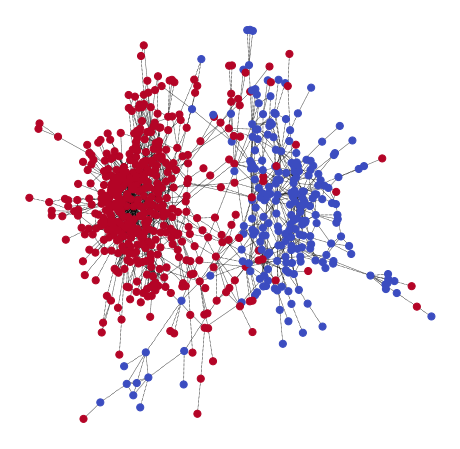

In [44]:
pmpd1 = sparse2th(pmpd1)
LG1 = G1.line_graph(backtracking=False)
z = model(G1, LG1, pmpd1)
_, pred = th.max(z, 1)
visualize(pred, nx_G1)

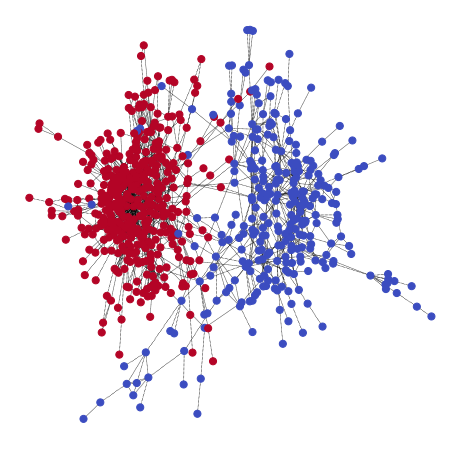

In [45]:
visualize(label1, nx_G1)